In [8]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import BatchNormalization

In [9]:
D1_LINEAR_GAUSIAN_227px = "D://227px_LI_GB_D1/"
D2_LINEAR_GAUSIAN_227px = "D://227px_LI_GB_D2/"
ds_type = D2_LINEAR_GAUSIAN_227px
dataset_path = signature_types = os.listdir(ds_type)
signs = []
for item in signature_types:
  all_signs = os.listdir(ds_type+"/"+item)
  for sign in all_signs:
    if sign.endswith(".db"):
      pass
    else: 
      signs.append((item, str(ds_type+"/"+item) + "/" + sign))
signs_df = pd.DataFrame(data = signs, columns = ["sign type", "image"])
sign_count = signs_df["sign type"].value_counts()
print("Signatures in each category:")
print(sign_count)

Signatures in each category:
genuine      887
forgeries    734
Name: sign type, dtype: int64


In [10]:
images = []
labels = []
for i in signature_types:
  data_path = ds_type + str(i)
  filenames = [i for i in os.listdir(data_path)]
  for f in tqdm(filenames, desc=f"Processing {i}"):
    if f.endswith(".db"):
      pass
    else:
      img = cv2.imread(data_path + "/" + f)
      images.append(img)
      labels.append(i)

Processing genuine: 100%|██████████| 887/887 [00:03<00:00, 276.94it/s]


In [11]:
images = np.array(images)
images = images.astype('float32') / 255.0

In [12]:
y = signs_df['sign type'].values
y = y.reshape(-1,1)
columnTransformer = ColumnTransformer([('encoder', OneHotEncoder(), [0])], remainder='passthrough')
Y=np.array(columnTransformer.fit_transform(y),dtype='float32')
print(Y.shape)

(1621, 2)


In [13]:
images, Y = shuffle(images,Y,random_state=42)
train_x,test_x,train_y,test_y = train_test_split(images, Y, test_size=0.2, random_state=42)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(1296, 227, 227, 3)
(325, 227, 227, 3)
(1296, 2)
(325, 2)


In [14]:
train_x = train_x / 255.0
test_x = test_x / 255.0

In [15]:
model = Sequential()
model.add(Conv2D(filters=96,strides=(4,4), kernel_size=(11,11),padding='valid',input_shape=(227,227,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(Conv2D(filters=256,strides=(1,1), kernel_size=(5,5),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(Conv2D(filters=384,strides=(1,1), kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=384,strides=(1,1), kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256,strides=(1,1), kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2), padding='valid'))
model.add(Flatten())
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=4096, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2,activation='sigmoid'))

In [16]:
# model.summary()

In [17]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
history = model.fit(train_x, train_y, validation_data=(test_x,test_y), epochs = 100)

Epoch 1/100
41/41 [==============================] - 10s 54ms/step - loss: 1.2243 - accuracy: 0.7269 - val_loss: 2.1723 - val_accuracy: 0.4462
Epoch 2/100
41/41 [==============================] - 1s 32ms/step - loss: 0.3596 - accuracy: 0.8565 - val_loss: 0.6884 - val_accuracy: 0.5538
Epoch 3/100
41/41 [==============================] - 1s 32ms/step - loss: 0.3035 - accuracy: 0.8704 - val_loss: 1.3121 - val_accuracy: 0.5538
Epoch 4/100
41/41 [==============================] - 1s 31ms/step - loss: 0.2568 - accuracy: 0.9020 - val_loss: 2.1207 - val_accuracy: 0.5538
Epoch 5/100
41/41 [==============================] - 1s 32ms/step - loss: 0.2380 - accuracy: 0.9074 - val_loss: 1.8250 - val_accuracy: 0.5538
Epoch 6/100
41/41 [==============================] - 1s 31ms/step - loss: 0.1940 - accuracy: 0.9290 - val_loss: 1.9110 - val_accuracy: 0.5538
Epoch 7/100
41/41 [==============================] - 1s 31ms/step - loss: 0.1781 - accuracy: 0.9336 - val_loss: 2.1650 - val_accuracy: 0.5538
Epoch

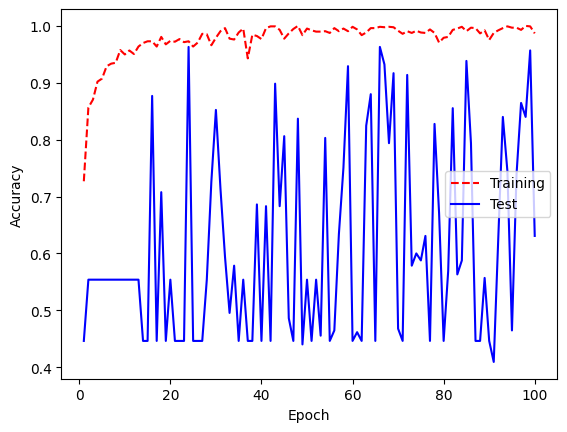

In [19]:
training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
epoch_count = range(1, len(training_acc) + 1)
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [20]:
testing = model.evaluate(test_x, test_y)
predictions = model.predict(test_x)
pred_y = np.argmax(predictions, axis = 1)
test_y = np.argmax(test_y, axis=1)
print(classification_report(test_y,pred_y))

11/11 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       1.00      0.17      0.29       145
           1       0.60      1.00      0.75       180

    accuracy                           0.63       325
   macro avg       0.80      0.59      0.52       325
weighted avg       0.78      0.63      0.55       325



In [21]:
cm = confusion_matrix(test_y, pred_y)
print(cm)

[[ 25 120]
 [  0 180]]
